In [1]:
!nvidia-smi

Sat Jul  6 03:49:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Install Required Dependencies

⚠ We need to rollback PyTorch version to install pre-built mmcv. Installation of mmcv from source may take hours.

In [2]:
!pip install -q torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 torchtext==0.16 --index-url https://download.pytorch.org/whl/cu121
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install -q mmcv==2.1.0 -f https://download.openmmlab.com/mmcv/dist/cu121/torch2.1/index.html
!pip install mmengine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 440.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 102.7 MB/s eta 0:00:00
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-ofzsn_cp
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-ofzsn_cp
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8260 sha256=3af7c35787abd25e8a086f1d1c09fc054754ca674c9c97fe653cb5ca8c6dd85

# Install MMDetection

In [3]:
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Cloning into 'mmdetection'...
remote: Enumerating objects: 38019, done.
remote: Total 38019 (delta 0), reused 0 (delta 0), pack-reused 38019
Receiving objects: 100% (38019/38019), 63.18 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (26232/26232), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdet


# Download Checkpoint File (Mask2Former)

In [4]:
!wget -P ./checkpoints https://download.openmmlab.com/mmdetection/v3.0/mask2former/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic_20220326_224553-3ec9e0ae.pth

--2024-07-06 03:52:32--  https://download.openmmlab.com/mmdetection/v3.0/mask2former/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic_20220326_224553-3ec9e0ae.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.199.246, 163.181.199.241, 163.181.199.245, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.199.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190084784 (181M) [application/octet-stream]
Saving to: ‘./checkpoints/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic_20220326_224553-3ec9e0ae.pth’

mask2former_swin-t- 100%[===================>] 181.28M   118MB/s    in 1.5s    

2024-07-06 03:52:33 (118 MB/s) - ‘./checkpoints/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic_20220326_224553-3ec9e0ae.pth’ saved [190084784/190084784]



# Load Mask2Former

In [5]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
# Choose to use a config and initialize the detector
config_file = '/content/mmdetection/configs/mask2former/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic.py'
# Setup a checkpoint file to load
checkpoint_file = '/content/mmdetection/checkpoints/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic_20220326_224553-3ec9e0ae.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'

Loads checkpoint by local backend from path: /content/mmdetection/checkpoints/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic_20220326_224553-3ec9e0ae.pth


# Run Inference Code

In [6]:
# Use the detector to do inference
image = mmcv.imread('demo/demo.jpg',channel_order='rgb')
result = inference_detector(model, image)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Load Visualizer

In [7]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


# Run Visualizer

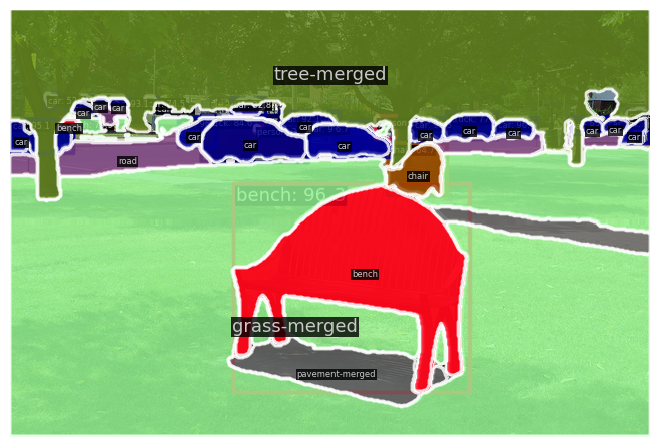

In [8]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

# Look into Result

The result of MMDetection panoptic segmentation model has four keys as below. <br />
We need to retrieve data from `pred_panoptic_seg` and `pred_instances`.

In [9]:
result.keys()

['ignored_instances', 'gt_instances', 'pred_panoptic_seg', 'pred_instances']

`pred_panoptic_seg` has only one key `sem_seg` of which shape is 1 x H x W. <br />
This arrary is a semantic segmentation result that shows pixel-wise classification.

In [10]:
print(result.pred_panoptic_seg.keys())
print(result.pred_panoptic_seg.sem_seg.shape)

['sem_seg']
torch.Size([1, 427, 640])


`pred_instances` has four keys `labels`, `scores`, `masks`, `bboxes`. <br />
They all have same length `n` that represents the number of objects in the image. <br />

In [11]:
print(result.pred_instances.keys())
print(result.pred_instances.labels.shape)
print(result.pred_instances.scores.shape)
print(result.pred_instances.masks.shape)
print(result.pred_instances.bboxes.shape)

['masks', 'scores', 'labels', 'bboxes']
torch.Size([68])
torch.Size([68])
torch.Size([68, 427, 640])
torch.Size([68, 4])


In [12]:
print(result.pred_instances.labels[0])
print(result.pred_instances.scores[0])
print(result.pred_instances.masks[0])
print(result.pred_instances.bboxes[0])

tensor(7, device='cuda:0')
tensor(0.1590, device='cuda:0')
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')
tensor([571., 110., 593., 127.], device='cuda:0')
